# Assign Clusters to Topics

In [1]:
import pandas as pd
from geopandas import GeoDataFrame
import numpy as np
from time import time
import shapely as shp
from shapely.geometry import Point
from shapely.wkt import loads
import folium
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
input_dir = '../data/input/'
output_dir = '../data/output/'

## Load clustered POIs

In [3]:
clustered_pois = pd.read_pickle(output_dir + 'pois_hdbscan_output_gdf.pkl')
print("POIs loaded: %s" % (len(clustered_pois.index)))
clustered_pois.head()

POIs loaded: 44930


,poi_id,poi_name,poi_kwds,geometry,label
0,N10287073,Wembley Central,"[transport, station]",POINT (518206.2277696228 185095.8309513291),64
3,N10606316,St John Street / Goswell Road,"[transport, busstop]",POINT (531464.3598053379 183078.4395275304),204
6,N11248823,Selhurst,"[transport, station]",POINT (533084.5780242808 167646.1388046202),38
7,N11248832,Thornton Heath,"[transport, station]",POINT (532252.1864341878 168358.7221607692),38
11,N11249226,Norwood Junction,"[transport, station]",POINT (534041.1170290327 168216.218479352),38


## Create a "document" for each cluster

In [4]:
cluster_kwds = dict()
for index, row in clustered_pois.iterrows():
    cluster_id, kwds = row['label'], row['poi_kwds']
    if cluster_id not in cluster_kwds:
        cluster_kwds[cluster_id] = ''
    for w in kwds:
        cluster_kwds[cluster_id] += w + ' '  
cluster_kwds

{64: 'transport station poi town transport busstop transport busstop transport busstop transport busstop shop butcher transport busstop transport busstop transport busstop transport busstop transport busstop transport busstop transport busstop transport busstop transport busstop transport busstop transport busstop transport busstop transport busstop transport busstop transport subway shop phone shop clothes shop departmentstore shop hairdresser shop hairdresser food fastfood accommodation hotel food fastfood pow islamic amenity library shop clothes money bank shop convenience shop clothes money bank money bank shop shoes health pharmacy shop convenience shop bakery shop confectionery tourist theatre shop hairdresser shop butcher shop convenience food fastfood shop convenience education college accommodation hotel food restaurant shop clothes shop departmentstore shop clothes shop clothes shop departmentstore money bank shop clothes shop phone shop convenience shop departmentstore healt

## Vectorize the corpus

In [5]:
vectorizer = CountVectorizer()
corpus_vectorized = vectorizer.fit_transform(cluster_kwds.values())

## Build the model

In [6]:
# Parameters to search for the best model
#num_topics = 3
num_topics = 10
#search_params = {'n_components': [num_topics], 'learning_decay': [.6]}
search_params = {'n_components': [num_topics]}

In [7]:
t0 = time()
lda = LatentDirichletAllocation(n_jobs = -1)
model = GridSearchCV(lda, param_grid=search_params, n_jobs = -1, cv=3)
model.fit(corpus_vectorized)
lda_model = model.best_estimator_
print("done in %0.3fs." % (time() - t0))
print(lda_model)

/home/user/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


done in 39.025s.
LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


## Save the model

In [8]:
#joblib.dump(lda_model, output_dir + 'clusters_hdbscan_lda_output_3.pkl') 
joblib.dump(lda_model, output_dir + 'clusters_hdbscan_lda_output_10.pkl') 

['../data/output/clusters_hdbscan_lda_output_10.pkl']

## Load the model

In [9]:
#lda_model = joblib.load(output_dir + 'clusters_hdbscan_lda_output_3.pkl')
lda_model = joblib.load(output_dir + 'clusters_hdbscan_lda_output_10.pkl')

## Top keywords per topic

In [10]:
n_words = 10

keywords = np.array(vectorizer.get_feature_names())
topic_keywords = []
for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:n_words]
    topic_keywords.append(keywords.take(top_keyword_locs))

topic_keywords = pd.DataFrame(topic_keywords)
topic_keywords.columns = ['Kwd '+ str(i) for i in range(topic_keywords.shape[1])]
topic_keywords.index = ['Topic '+ str(i) for i in range(topic_keywords.shape[0])]
topic_keywords

,Kwd 0,Kwd 1,Kwd 2,Kwd 3,Kwd 4,Kwd 5,Kwd 6,Kwd 7,Kwd 8,Kwd 9
Topic 0,education,transport,busstop,school,shop,pow,christian,health,food,amenity
Topic 1,shop,university,food,education,memorial,tourist,cafe,pub,transport,busstop
Topic 2,terminal,airport,basketball,baseball,stadium,gym,shooting,iceskating,butcher,hindu
Topic 3,shop,food,departmentstore,hairdresser,transport,busstop,convenience,restaurant,fastfood,cafe
Topic 4,shop,clothes,food,departmentstore,restaurant,transport,busstop,cafe,money,shoes
Topic 5,transport,busstop,shop,food,education,school,pub,supermarket,station,pow
Topic 6,transport,busstop,food,shop,fastfood,convenience,tourist,cafe,pub,station
Topic 7,food,shop,restaurant,cafe,departmentstore,fastfood,tourist,pub,clothes,bar
Topic 8,food,accommodation,hotel,shop,restaurant,cafe,transport,departmentstore,fastfood,convenience
Topic 9,transport,busstop,food,bank,money,shop,restaurant,pub,fastfood,subway


## Visualize the model

In [11]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, corpus_vectorized, vectorizer)
panel

/home/user/miniconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.069405 -0.041230       1        1  29.094721
7     -0.173565 -0.031456       2        1  18.371779
4     -0.128178 -0.033529       3        1  15.021543
5      0.217838 -0.069499       4        1  13.470198
6      0.061077 -0.024539       5        1   9.471806
9      0.087784 -0.083415       6        1   6.371559
0      0.180109 -0.036559       7        1   3.906207
8     -0.153750 -0.045423       8        1   3.255461
1     -0.062655  0.038256       9        1   1.011352
2      0.040745  0.327394      10        1   0.025374, topic_info=     Category          Freq             Term         Total  loglift  logprob
term                                                                        
144   Default   8991.000000        transport   8991.000000  30.0000   30.000
22    Default   8012.000000          busstop   8012.000000  29.0000   29.000
119   Default  17288.000000             shop  17288.000000  28.0000   28.000
54    Default  10805.000000             food  10805.000000  27.0000   27.000
33    Default   2196.000000          clothes   2196.000000  26.0000   26.000
47    Default   1106.000000        education   1106.000000  25.0000   25.000
113   Default   3962.000000       restaurant   3962.000000  24.0000   24.000
24    Default   2594.000000             cafe   2594.000000  23.0000   23.000
44    Default   4777.000000  departmentstore   4777.000000  22.0000   22.000
0     Default    599.000000    accommodation    599.000000  21.0000   21.000
73    Default    555.000000            hotel    555.000000  20.0000   20.000
115   Default    815.000000           school    815.000000  19.0000   19.000
137   Default   1150.000000          tourist   1150.000000  18.0000   18.000
109   Default   1625.000000              pub   1625.000000  17.0000   17.000
107   Default    983.000000              pow    983.000000  16.0000   16.000
64    Default   2102.000000      hairdresser   2102.000000  15.0000   15.000
50    Default   2077.000000         fastfood   2077.000000  14.0000   14.000
29    Default    843.000000        christian    843.000000  13.0000   13.000
90    Default    935.000000            money    935.000000  12.0000   12.000
38    Default   1648.000000      convenience   1648.000000  11.0000   11.000
9     Default    820.000000             bank    820.000000  10.0000   10.000
66    Default   1150.000000           health   1150.000000   9.0000    9.000
4     Default    624.000000          amenity    624.000000   8.0000    8.000
88    Default    213.000000         memorial    213.000000   7.0000    7.000
117   Default    361.000000            shoes    361.000000   6.0000    6.000
79    Default    287.000000          jewelry    287.000000   5.0000    5.000
82    Default    526.000000          landuse    526.000000   4.0000    4.000
83    Default    551.000000       laundrette    551.000000   3.0000    3.000
129   Default    843.000000      supermarket    843.000000   2.0000    2.000
10    Default    521.000000              bar    521.000000   1.0000    1.000
...       ...           ...              ...           ...      ...      ...
135   Topic10      0.148058        themepark      3.076545   5.2452   -5.037
60    Topic10      0.148058             golf      4.045212   4.9715   -5.037
75    Topic10      0.148058       iceskating      4.081781   4.9625   -5.037
21    Topic10      0.148058         buddhist      5.037590   4.7521   -5.037
63    Topic10      0.148058              gym      5.057343   4.7482   -5.037
114   Topic10      0.148058            ruins      5.073967   4.7449   -5.037
32    Topic10      0.148058         climbing      5.889222   4.5959   -5.037
116   Topic10      0.148058            scrub      5.898623   4.5943   -5.037
133   Topic10      0.148058         terminal      6.986872   4.4250   -5.037
125   Topic10      0.148058          stadium     15.583064   3.6229   -5.03

##  Topics per cluster

In [12]:
lda_output = lda_model.transform(corpus_vectorized)
topic_names = ["Topic" + str(i) for i in range(lda_model.n_components)]
cluster_names = cluster_kwds.keys()
df_cluster_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=cluster_names).sort_index()
dominant_topic = np.argmax(df_cluster_topic.values, axis=1)
df_cluster_topic['Dominant Topic'] = dominant_topic
df_cluster_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Dominant Topic
0,0.00,0.00,0.0,0.17,0.00,0.82,0.00,0.00,0.00,0.00,5
1,0.00,0.00,0.0,0.00,0.00,0.99,0.00,0.00,0.00,0.00,5
2,0.07,0.00,0.0,0.00,0.00,0.92,0.00,0.00,0.01,0.00,5
3,0.06,0.00,0.0,0.00,0.00,0.78,0.15,0.00,0.00,0.00,5
4,0.68,0.00,0.0,0.00,0.00,0.31,0.00,0.00,0.00,0.00,0
5,0.00,0.00,0.0,0.00,0.00,0.88,0.02,0.00,0.00,0.11,5
6,0.00,0.00,0.0,0.13,0.41,0.40,0.00,0.00,0.01,0.05,4
7,0.00,0.00,0.0,0.07,0.00,0.26,0.00,0.00,0.00,0.67,9
8,0.00,0.00,0.0,0.79,0.00,0.00,0.00,0.00,0.00,0.21,3
9,0.00,0.00,0.0,0.00,0.00,1.00,0.00,0.00,0.00,0.00,5


## Topics distribution across clusters

In [13]:
df_topic_distribution = df_cluster_topic['Dominant Topic'].value_counts().reset_index(name="Num Clusters")
df_topic_distribution.columns = ['Topic Num', 'Num Regions']
df_topic_distribution

,Topic Num,Num Regions
0,3,96
1,5,35
2,7,28
3,6,22
4,4,19
5,9,18
6,0,6
7,8,3
8,1,2


## Compute cluster borders

In [14]:
cluster_borders = clustered_pois.groupby(['label'], sort=False)['geometry'].agg([list, np.size])
geom = [shp.geometry.MultiPoint(x).convex_hull for x in cluster_borders['list']]
cluster_borders = GeoDataFrame(cluster_borders, crs=clustered_pois.crs, geometry=geom).drop(columns=['list'])
cluster_borders

,size,geometry
label,,
64,233,"POLYGON ((518149.7491404874 184774.9022772649,..."
204,733,"POLYGON ((531553.713469136 182913.0571938086, ..."
38,1460,"POLYGON ((532333.7318541205 162712.3969356806,..."
107,241,"POLYGON ((535164.51409401 171394.4423554202, 5..."
123,148,"POLYGON ((536363.8468193049 176705.8921681166,..."
222,223,"POLYGON ((526730.4501445381 181054.1304096835,..."
202,345,"POLYGON ((527225.4284611931 179118.4306300416,..."
100,257,"POLYGON ((540563.468904967 189548.9915763995, ..."
102,72,"POLYGON ((540529.8927677292 188174.2678898686,..."


## Assign topic labels to clusters

In [15]:
cluster_borders_labeled = pd.merge(cluster_borders, df_cluster_topic, left_index=True, right_index=True, how = 'inner')
cluster_borders_labeled

,size,geometry,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Dominant Topic
64,233,"POLYGON ((518149.7491404874 184774.9022772649,...",0.00,0.00,0.0,0.65,0.32,0.00,0.00,0.00,0.03,0.00,3
204,733,"POLYGON ((531553.713469136 182913.0571938086, ...",0.00,0.00,0.0,0.30,0.16,0.02,0.13,0.36,0.00,0.03,7
38,1460,"POLYGON ((532333.7318541205 162712.3969356806,...",0.06,0.00,0.0,0.49,0.08,0.25,0.03,0.06,0.02,0.00,3
107,241,"POLYGON ((535164.51409401 171394.4423554202, 5...",0.07,0.00,0.0,0.17,0.09,0.00,0.57,0.06,0.00,0.04,6
123,148,"POLYGON ((536363.8468193049 176705.8921681166,...",0.12,0.35,0.0,0.00,0.00,0.00,0.26,0.27,0.00,0.00,1
222,223,"POLYGON ((526730.4501445381 181054.1304096835,...",0.00,0.01,0.0,0.13,0.00,0.00,0.00,0.14,0.72,0.00,8
202,345,"POLYGON ((527225.4284611931 179118.4306300416,...",0.00,0.00,0.0,0.00,0.93,0.00,0.00,0.00,0.07,0.00,4
100,257,"POLYGON ((540563.468904967 189548.9915763995, ...",0.06,0.00,0.0,0.62,0.06,0.08,0.00,0.11,0.00,0.06,3
102,72,"POLYGON ((540529.8927677292 188174.2678898686,...",0.00,0.00,0.0,0.13,0.00,0.15,0.00,0.00,0.00,0.72,9
106,337,"POLYGON ((539121.8398796491 185839.9056566295,...",0.00,0.00,0.0,0.60,0.02,0.09,0.23,0.00,0.00,0.06,3


## Assign colors to clusters

In [16]:
def style_gen_mixed(row):
    r, g, b = (int) (row['Topic0'] * 255), (int) (row['Topic1'] * 255), (int) (row['Topic2'] * 255)
    color = '#{:02x}{:02x}{:02x}'.format(r, g, b)
    return {'fillColor': color, 'weight': 2, 'color': 'black', 'fillOpacity': 0.8}

def style_gen_dominant(row):
    cmap = cm.get_cmap('tab10')
    rgb = cmap(row['Dominant Topic'])
    color = matplotlib.colors.rgb2hex(rgb)
    return {'fillColor': color, 'weight': 2, 'color': 'black', 'fillOpacity': 0.8}

def style_gen_topic(row, topic):
    cmap = cm.get_cmap('Reds')
    rgb = cmap(row[topic])
    color = matplotlib.colors.rgb2hex(rgb)
    return {'fillColor': color, 'weight': 2, 'color': 'black', 'fillOpacity': 0.8}

# def style_gen_dominant_rgb(row):
#     if row['Dominant Topic'] == 0:
#         r, g, b = 255, 0, 0
#     elif row['Dominant Topic'] == 1:
#         r, g, b = 0, 255, 0
#     else:
#         r, g, b = 0, 0, 255
#     color = '#{:02x}{:02x}{:02x}'.format(r, g, b)
#     return {'fillColor': color, 'weight': 2, 'color': 'black', 'fillOpacity': 0.8}

In [17]:
# Mixed RGB color based on the distribution across 3 topics
#cluster_borders_labeled['style'] = cluster_borders_labeled.apply(lambda row: style_gen_mixed(row), axis=1)

# Color based on the dominant topic
cluster_borders_labeled['style'] = cluster_borders_labeled.apply(lambda row: style_gen_dominant(row), axis=1)

# Color based on a given topic
#cluster_borders_labeled['style'] = cluster_borders_labeled.apply(lambda row: style_gen_topic(row, 'Topic4'), axis=1)

cluster_borders_labeled

,size,geometry,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Dominant Topic,style
64,233,"POLYGON ((518149.7491404874 184774.9022772649,...",0.00,0.00,0.0,0.65,0.32,0.00,0.00,0.00,0.03,0.00,3,"{'fillColor': '#d62728', 'weight': 2, 'color':..."
204,733,"POLYGON ((531553.713469136 182913.0571938086, ...",0.00,0.00,0.0,0.30,0.16,0.02,0.13,0.36,0.00,0.03,7,"{'fillColor': '#7f7f7f', 'weight': 2, 'color':..."
38,1460,"POLYGON ((532333.7318541205 162712.3969356806,...",0.06,0.00,0.0,0.49,0.08,0.25,0.03,0.06,0.02,0.00,3,"{'fillColor': '#d62728', 'weight': 2, 'color':..."
107,241,"POLYGON ((535164.51409401 171394.4423554202, 5...",0.07,0.00,0.0,0.17,0.09,0.00,0.57,0.06,0.00,0.04,6,"{'fillColor': '#e377c2', 'weight': 2, 'color':..."
123,148,"POLYGON ((536363.8468193049 176705.8921681166,...",0.12,0.35,0.0,0.00,0.00,0.00,0.26,0.27,0.00,0.00,1,"{'fillColor': '#ff7f0e', 'weight': 2, 'color':..."
222,223,"POLYGON ((526730.4501445381 181054.1304096835,...",0.00,0.01,0.0,0.13,0.00,0.00,0.00,0.14,0.72,0.00,8,"{'fillColor': '#bcbd22', 'weight': 2, 'color':..."
202,345,"POLYGON ((527225.4284611931 179118.4306300416,...",0.00,0.00,0.0,0.00,0.93,0.00,0.00,0.00,0.07,0.00,4,"{'fillColor': '#9467bd', 'weight': 2, 'color':..."
100,257,"POLYGON ((540563.468904967 189548.9915763995, ...",0.06,0.00,0.0,0.62,0.06,0.08,0.00,0.11,0.00,0.06,3,"{'fillColor': '#d62728', 'weight': 2, 'color':..."
102,72,"POLYGON ((540529.8927677292 188174.2678898686,...",0.00,0.00,0.0,0.13,0.00,0.15,0.00,0.00,0.00,0.72,9,"{'fillColor': '#17becf', 'weight': 2, 'color':..."
106,337,"POLYGON ((539121.8398796491 185839.9056566295,...",0.00,0.00,0.0,0.60,0.02,0.09,0.23,0.00,0.00,0.06,3,"{'fillColor': '#d62728', 'weight': 2, 'color':..."


## Display colormap and topics

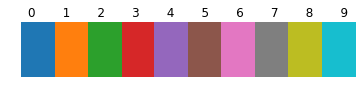

,Kwd 0,Kwd 1,Kwd 2,Kwd 3,Kwd 4,Kwd 5,Kwd 6,Kwd 7,Kwd 8,Kwd 9
Topic 0,education,transport,busstop,school,shop,pow,christian,health,food,amenity
Topic 1,shop,university,food,education,memorial,tourist,cafe,pub,transport,busstop
Topic 2,terminal,airport,basketball,baseball,stadium,gym,shooting,iceskating,butcher,hindu
Topic 3,shop,food,departmentstore,hairdresser,transport,busstop,convenience,restaurant,fastfood,cafe
Topic 4,shop,clothes,food,departmentstore,restaurant,transport,busstop,cafe,money,shoes
Topic 5,transport,busstop,shop,food,education,school,pub,supermarket,station,pow
Topic 6,transport,busstop,food,shop,fastfood,convenience,tourist,cafe,pub,station
Topic 7,food,shop,restaurant,cafe,departmentstore,fastfood,tourist,pub,clothes,bar
Topic 8,food,accommodation,hotel,shop,restaurant,cafe,transport,departmentstore,fastfood,convenience
Topic 9,transport,busstop,food,bank,money,shop,restaurant,pub,fastfood,subway


In [18]:
gradient = np.vstack((np.linspace(0, 1, 256), np.linspace(0, 1, 256)))
fig, axis = plt.subplots(nrows=1)
t = list(range(num_topics))
t = [str(x) for x in t]
t = '       '.join(t)
axis.set_title(t)
axis.imshow(gradient, aspect='auto', cmap=plt.get_cmap('tab10'))
pos = list(axis.get_position().bounds)
x_text, y_text = pos[0] - 0.01, pos[1] + pos[3]/2.
axis.set_axis_off()
fig.set_figheight(1)
plt.show()

topic_keywords

## Visualize clusters

In [19]:
map_center = [51.507222, -0.1275] # London
m = folium.Map(location=map_center, zoom_start=12, tiles='OpenStreetMap', width=900, height=600)
folium.GeoJson(cluster_borders_labeled).add_to(m)
m